In [1]:
import os
os.chdir("../")

In [2]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

import matplotlib as mpl

# display all lines pandas
pd.set_option("display.max_rows", None)

mpl.rcParams.update({
    "figure.figsize": (6, 4),          
    "font.size": 10,                   
    "axes.labelsize": 10,              
    "axes.titlesize": 10,              
    "legend.fontsize": 9,              
    "xtick.labelsize": 9,              
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,            
    "lines.markersize": 5,             
    "axes.grid": True,                 
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "legend.frameon": False,           
    "pdf.fonttype": 42,                
    "ps.fonttype": 42,
    "savefig.bbox": "tight",           
    "savefig.dpi": 300,                
})

colors = [
    "#9467bd",
    "#2ca02c",
    "#bcbd22",
    "#7f7f7f",
    "#e377c2",
    "#8c564b",
    "#d62728",
    "#17becf",
    "#1f77b4",
    "#ff7f0e",
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
    

from ppm.wandb_utils import fetch_experiments

project = "multi-task-icpm"
results_dir = os.path.join("notebooks", f"{project}.csv")
if os.path.exists(results_dir):
    results = pd.read_csv(results_dir)
else:
    results = fetch_experiments(project=project, include_metrics=True)
    results.to_csv(results_dir, index=False)
    
results.groupby(["log", "backbone"]).size()

log                      backbone  
BPI12                    llama32-1b      8
                         pm-gpt2        14
                         qwen25-05b      7
                         rnn           144
BPI17                    llama32-1b      7
                         pm-gpt2        14
                         qwen25-05b      7
                         rnn           144
BPI20PrepaidTravelCosts  llama32-1b      7
                         pm-gpt2        14
                         qwen25-05b     10
                         rnn           145
BPI20RequestForPayment   llama32-1b      7
                         pm-gpt2        14
                         qwen25-05b     10
                         rnn           144
BPI20TravelPermitData    llama32-1b      7
                         pm-gpt2        14
                         qwen25-05b     10
                         rnn           144
dtype: int64

In [3]:
def fetch_single(wandb_id, targets=["na", "rt"], project_name="multi-task-icpm"):
    if isinstance(targets, str):
        targets = [targets]
        
    api = wandb.Api()
    run = api.run(f"raseidi/{project_name}/{wandb_id}")
    history = run.scan_history()

    na_acc, na_loss, rt_loss = None, None, None
    if "rt" in targets:
        rt_loss = [row["test_next_remaining_time_loss"] for row in history]
        
    if "na" in targets:
        na_loss = [row["test_next_activity_loss"] for row in history]
        na_acc = [row["test_next_activity_acc"] for row in history]
    return na_acc, na_loss, rt_loss

## Experimental setup

- datasets' characteristics
- architectures and illustrations
- param count

### Datasets

In [4]:
from skpm.event_logs import (
    BPI12,
    BPI17,
    BPI20PrepaidTravelCosts,
    BPI20TravelPermitData,
    BPI20RequestForPayment,
)

logs = [
    BPI12,
    BPI17,
    BPI20PrepaidTravelCosts,
    BPI20TravelPermitData,
    BPI20RequestForPayment,
]

properties = pd.DataFrame()
for log in logs:
    df = log().dataframe
    
    p = {
        "Log": log.__name__,
        "# cases": len(df["case:concept:name"].unique()),
        "# evt.": len(df),
        "# act.": len(df["concept:name"].unique()),
        "tlmean": df.groupby("case:concept:name").size().mean(),
        "tlstd": df.groupby("case:concept:name").size().std(),
    }
    
    p = pd.DataFrame(p, index=[0])
    properties = pd.concat([properties, p], ignore_index=True)

In [5]:
properties['Trace length'] = properties.apply(
    lambda row: f"{row['tlmean']:.4f}±{row['tlstd']:.1f}",
    axis=1
)
properties = properties.drop(columns=["tlmean", "tlstd"])
properties.sort_values(by="# evt.").round(4).to_csv("notebooks/log_properties.csv", index=False)
properties.sort_values(by="# evt.").round(4)

,Log,# cases,# evt.,# act.,Trace length
2,BPI20PrepaidTravelCosts,2099,18246,29,8.6927±2.3
4,BPI20RequestForPayment,6886,36796,19,5.3436±1.5
3,BPI20TravelPermitData,7065,86581,51,12.2549±5.6
0,BPI12,13087,262200,24,20.0351±19.9
1,BPI17,31509,1202267,26,38.1563±16.7


### Architecture illustration

In [3]:
from ppm.models import NextEventPredictor

rnn_example = NextEventPredictor(
    embedding_size=32,
    categorical_cols=["activity"],
    numerical_cols=["accumulated_time"],
    categorical_sizes={
        "activity": 20,
    },
    categorical_targets=["activity"],
    numerical_targets=["remaining_time"],
    backbone_name="rnn",
    backbone_hidden_size=64,
    backbone_n_layers=2,
    padding_idx=0,
    strategy="sum",
    backbone_pretrained=False,
    backbone_finetuning=None,
    backbone_type="lstm",
    device="cuda",
)
rnn_example

/home/seidi/Repositories/trash_repos/llm-peft-ppm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NextEventPredictor(
  (in_layer): InLayer(
    (embedding_layers): ModuleDict(
      (activity): Embedding(20, 32, padding_idx=0)
    )
    (continuous_layer): Linear(in_features=1, out_features=32, bias=True)
    (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (backbone): LSTM(32, 64, num_layers=2, batch_first=True)
  (out_layers): ModuleDict(
    (activity): OutLayer(
      (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Linear(in_features=64, out_features=20, bias=True)
    )
    (remaining_time): OutLayer(
      (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [4]:
from peft import LoraConfig, TaskType

fine_tuning = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=2,
    lora_alpha=4,
    use_rslora=True,
)

# NOTE: you must set the enviroment variable HF_TOKEN on your local machine to access models from the huggingface hub
qwen_input_size = 896
qwen_example = NextEventPredictor(
    embedding_size=qwen_input_size,
    categorical_cols=["activity"],
    numerical_cols=["accumulated_time"],
    categorical_sizes={
        "activity": 20,
    },
    categorical_targets=["activity"],
    numerical_targets=["remaining_time"],
    backbone_name="Qwen/Qwen2.5-0.5B",
    backbone_pretrained=True,
    backbone_hidden_size=qwen_input_size,
    backbone_finetuning=fine_tuning,
    
    backbone_type=None,
    backbone_n_layers=None,
    padding_idx=0,
    strategy="sum",
    device="cpu",   # just for testing
)
print(qwen_example)
del qwen_example

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


NextEventPredictor(
  (in_layer): InLayer(
    (embedding_layers): ModuleDict(
      (activity): Embedding(20, 896, padding_idx=0)
    )
    (continuous_layer): Linear(in_features=1, out_features=896, bias=True)
    (layer_norm): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
  )
  (backbone): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=2, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=2, out_features

In [6]:
from ppm.models.config import FreezeConfig

freeze_config = FreezeConfig(
    ix_layers=[0, 1, 2],
    module_path="layers",
)

# NOTE: you must set the enviroment variable HF_TOKEN on your local machine to access models from the huggingface hub
llama_input_size = 2048
llama_example = NextEventPredictor(
    embedding_size=llama_input_size,
    categorical_cols=["activity"],
    numerical_cols=["accumulated_time"],
    categorical_sizes={
        "activity": 20,
    },
    categorical_targets=["activity"],
    numerical_targets=["remaining_time"],
    backbone_name="meta-llama/Llama-3.2-1B",
    backbone_pretrained=True,
    backbone_hidden_size=llama_input_size,
    backbone_finetuning=freeze_config,
    
    backbone_type=None,
    backbone_n_layers=None,
    padding_idx=0,
    strategy="sum",
    device="cpu",   # just for testing
)
print(llama_example)

NextEventPredictor(
  (in_layer): InLayer(
    (embedding_layers): ModuleDict(
      (activity): Embedding(20, 2048, padding_idx=0)
    )
    (continuous_layer): Linear(in_features=1, out_features=2048, bias=True)
    (layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (backbone): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=819

Illustrating how the freezing fine-tuning works.

In the `freeze_config` we pass as argument a list of `ix_layers` indicating which layer must be fine-tuned. In this case, we are fine-tuning the three first layers. All the other layers are frozen.

In [7]:
# check frozen layers

LAYER_TO_TUNE = 0
LAYER_TO_FREEZE = 3

print("Tuning layer[0]:")    
for name, param in llama_example.backbone.layers[LAYER_TO_TUNE].named_parameters():
    print(name, param.requires_grad)

print("-"*80 + "\nFreezing layer[3]:")    
for name, param in llama_example.backbone.layers[LAYER_TO_FREEZE].named_parameters():
    print(name, param.requires_grad)

del llama_example

Tuning layer[0]:
self_attn.q_proj.weight True
self_attn.k_proj.weight True
self_attn.v_proj.weight True
self_attn.o_proj.weight True
mlp.gate_proj.weight True
mlp.up_proj.weight True
mlp.down_proj.weight True
input_layernorm.weight True
post_attention_layernorm.weight True
--------------------------------------------------------------------------------
Freezing layer[3]:
self_attn.q_proj.weight False
self_attn.k_proj.weight False
self_attn.v_proj.weight False
self_attn.o_proj.weight False
mlp.gate_proj.weight False
mlp.up_proj.weight False
mlp.down_proj.weight False
input_layernorm.weight True
post_attention_layernorm.weight True


## Experimental evaluation

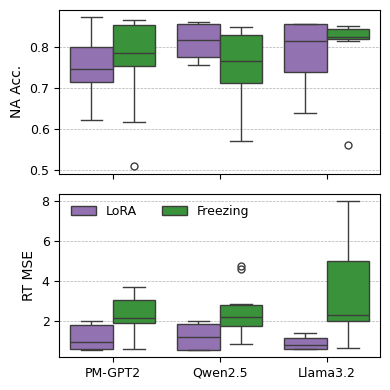

In [ ]:
multi_task_results = results[
    (~results["test_next_remaining_time_loss"].isna()) &
    (~results["test_next_activity_loss"].isna()) &
    (results.log.isin(["BPI12", "BPI17"])) & # just to smooth the plot
    (results.backbone.str.startswith(('qwen', 'llama', 'pm-gpt'))) &
    ((results["r"].isin([128, 256])) | (results["r"].isna()))
].copy()

backbone_mapping = {
    "llama32-1b": "Llama3.2",
    "qwen25-05b": "Qwen2.5",
    "pm-gpt2": "PM-GPT2",
}
multi_task_results["backbone"] = multi_task_results["backbone"].map(backbone_mapping)
multi_task_results["fine_tuning"] = multi_task_results["fine_tuning"].map({
    "lora": "LoRA",
    "freeze": "Freezing",
})

fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True, dpi=100)

order = ["PM-GPT2", "Qwen2.5", "Llama3.2"]
sns.boxplot(
    data=multi_task_results,
    x="backbone",
    y="test_next_activity_acc",
    hue="fine_tuning",
    ax=ax[0],
    order=order,
)
sns.boxplot(
    data=multi_task_results,
    x="backbone",
    y="test_next_remaining_time_loss",
    hue="fine_tuning",
    ax=ax[1],
    order=order,
)
ax[0].set_ylabel("NA Acc.")
ax[1].set_ylabel("RT MSE")
ax[0].set_title("")
ax[1].set_title("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].legend().remove()
ax[1].legend(title="", ncol=2, loc="upper left")

plt.tight_layout()
plt.savefig(f"/home/seidi/Repositories/papers/icpm25-paper/figures/results/loss_distribution.pdf", dpi=300)

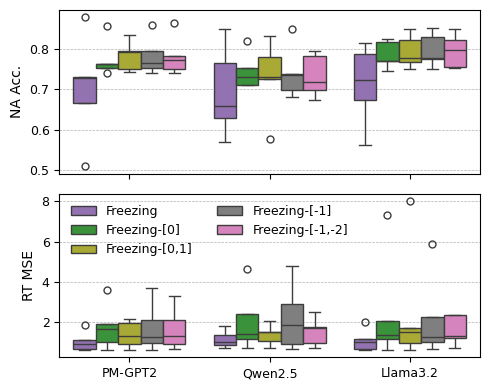

In [ ]:
import numpy as np
LOGS_TO_PLOT = ["BPI20PrepaidTravelCosts", "BPI12", "BPI17"]
HUE_ORDER=["Freezing", "Freezing-[0]", "Freezing-[0,1]", "Freezing-[-1]", "Freezing-[-1,-2]"]
HUE_MAP = {
    "pm-gpt2": "PM-GPT2", 
    "qwen25-05b": "Qwen2.5", 
    "llama32-1b": "Llama3.2"
}
ORDER = ["PM-GPT2", "Qwen2.5", "Llama3.2"]
peft = results[
    (results.fine_tuning.isin(("freeze",)))
    # & (results.log.isin(LOGS_TO_PLOT))
    # & (results.r != 128)
    & (results.strategy != "concat")
].reset_index(drop=True).copy()
peft.backbone = peft.backbone.map(HUE_MAP)
peft.fine_tuning = peft.fine_tuning.map({
    "lora": "LoRA",
    "freeze": "Freezing",
})
peft.fine_tuning = np.where(peft.freeze_layers.isna(), peft.fine_tuning, peft.fine_tuning + "-[" + peft.freeze_layers.astype(str) + "]")

fig, ax = plt.subplots(2, 1, figsize=(5, 4), dpi=100, sharex=True)
sns.boxplot(
    x="backbone",
    y="test_next_activity_acc",
    hue="fine_tuning",
    hue_order=HUE_ORDER,
    order=ORDER,
    data=peft,
    ax=ax[0],
)
sns.boxplot(
    x="backbone",
    y="test_next_remaining_time_loss",
    hue="fine_tuning",
    hue_order=HUE_ORDER,
    order=ORDER,
    data=peft,
    ax=ax[1],
)
ax[0].set_xlabel("")
ax[0].set_ylabel("NA Acc.")
ax[1].set_xlabel("")
ax[1].set_ylabel("RT MSE")
# plt.legend(title="", ncol=2)
ax[0].legend().remove()
ax[1].legend(title="", ncol=2, loc="upper left")
plt.tight_layout()
plt.savefig(f"/home/seidi/Repositories/papers/icpm25-paper/figures/results/loss_distribution_freezing.pdf", dpi=300)

## Checking best models

In [10]:
project = "ppm-llm-confidence"
results_dir = os.path.join("notebooks", f"best_configs.csv")
if os.path.exists(results_dir):
    best_results = pd.read_csv(results_dir)
else:
    best_results = fetch_experiments(project=project, include_metrics=True)
    best_results.to_csv(results_dir, index=False)
    
best_results.groupby(["log", "backbone"]).size()

cols = [
    "id", 
    "log", 
    "backbone", 
    "test_next_activity_acc", 
    "test_next_activity_loss", 
    "test_next_remaining_time_loss", 
    "project", 
    "best_test_next_activity_acc", 
    "best_test_next_activity_loss", 
    "best_test_next_remaining_time_loss",
    "trainable_params",
    "total_params",
    "fine_tuning",
    "_runtime"
]
best_gpt = results[
    (~results["test_next_remaining_time_loss"].isna()) &
    (~results["test_next_activity_loss"].isna()) &
    (results["log"] != "BPI19") &
    (results["backbone"].str.startswith(("pm",))) &
    (results.strategy=="sum") 
].copy().reset_index(drop=True)
best_gpt_ix = best_gpt.groupby(["log", "backbone"])["test_next_remaining_time_loss"].nsmallest(1).index.get_level_values(2)
best_gpt["project"] = "multi-task-icpm"
best_gpt = best_gpt.iloc[best_gpt_ix][cols]

# BPI20TravelPermitData crashed when reproducing the best results; so let's just reuse the ones from the original experiments
# we only have llama32-1b and pm-gpt2
best_bpi20tpd = results[
    (~results["test_next_remaining_time_loss"].isna()) &
    (~results["test_next_activity_loss"].isna()) &
    (results["log"] == "BPI20TravelPermitData") &
    (results["backbone"].str.startswith(("qwen",))) #, "rnn")))
].copy().reset_index(drop=True)
best_bpi20tpd_ix = best_bpi20tpd.groupby(["log", "backbone"])["test_next_remaining_time_loss"].nsmallest(1).index.get_level_values(2)
best_bpi20tpd["project"] = "multi-task-icpm"
best_bpi20tpd = best_bpi20tpd.iloc[best_bpi20tpd_ix][cols]

best_rnn = results[
    (~results["test_next_remaining_time_loss"].isna()) &
    (~results["test_next_activity_loss"].isna()) &
    (results["log"] != "BPI19") &
    (results["backbone"].str.startswith(("rnn",))) &
    (results.strategy=="sum")
].copy().reset_index(drop=True)
best_rnn_ix = best_rnn.groupby(["log", "backbone"])["test_next_remaining_time_loss"].nsmallest(1).index.get_level_values(2)
best_rnn["project"] = "multi-task-icpm"
best_rnn = best_rnn.iloc[best_rnn_ix][cols]

best_results = best_results[best_results.backbone != "rnn"]
best_results["project"] = "ppm-llm-confidence"
best = pd.concat((best_results[cols], best_gpt[cols], best_bpi20tpd[cols], best_rnn[cols]), axis=0)
best.groupby(["log"]).size() 

log
BPI12                      4
BPI17                      4
BPI20PrepaidTravelCosts    4
BPI20RequestForPayment     4
BPI20TravelPermitData      4
dtype: int64

In [11]:
# best single-task models
sng_best_rt = results[
    (~results["test_next_remaining_time_loss"].isna()) &
    (results["test_next_activity_loss"].isna()) &
    (results["backbone"] == "rnn") &
    (results["strategy"] == "sum") &
    (results["log"] != "BPI19")
].sort_values(by="test_next_remaining_time_loss", ascending=True).reset_index(drop=True)

sng_best_na = results[
    (results["test_next_remaining_time_loss"].isna()) &
    (~results["test_next_activity_loss"].isna()) &
    (results["backbone"] == "rnn")  &
    (results["strategy"] == "sum") &
    (results["log"] != "BPI19")
].sort_values(by="test_next_activity_loss", ascending=True).reset_index(drop=True)
sng_best_na["project"] = "multi-task-icpm"
sng_best_rt["project"] = "multi-task-icpm"

sng_best_na_ix = sng_best_na.groupby(["log", "backbone"])["test_next_activity_loss"].nsmallest(1).index.get_level_values(2)
sng_best_rt_ix = sng_best_rt.groupby(["log", "backbone"])["test_next_remaining_time_loss"].nsmallest(1).index.get_level_values(2)

sng_best_na = sng_best_na.iloc[sng_best_na_ix]
sng_best_rt = sng_best_rt.iloc[sng_best_rt_ix]
sng_best_na
na_cols_to_drop = [
    "test_next_remaining_time_loss", 
    "train_next_remaining_time_loss",
    "best_test_next_remaining_time_loss",
    "best_train_next_remaining_time_loss",
]
rt_cols_to_drop = [
    "test_next_activity_loss", 
    "train_next_activity_loss",
    "best_test_next_activity_loss",
    "best_train_next_activity_loss",
    "test_next_activity_acc", 
    "train_next_activity_acc",
    "best_test_next_activity_acc",
    "best_train_next_activity_acc",   
]

sg_best = pd.merge(
    sng_best_na.drop(na_cols_to_drop, axis=1),
    sng_best_rt[["log", "backbone"] + na_cols_to_drop],
    on=["log", "backbone"],
    suffixes=("_na", "_rt"),
)
sg_best["backbone"] = "ST-RNN"
sg_best.head()

,r,lr,log,device,epochs,backbone,n_layers,rnn_type,strategy,grad_clip,...,train_next_activity_acc,train_next_activity_loss,test_next_activity_acc,_runtime,_step,project,test_next_remaining_time_loss,train_next_remaining_time_loss,best_test_next_remaining_time_loss,best_train_next_remaining_time_loss
0,NaN,0.0005,BPI12,cuda,25,ST-RNN,1,lstm,sum,5,...,0.857520,0.343186,0.833786,39.576245,24,multi-task-icpm,1.744122,0.612834,1.455503,0.612834
1,NaN,0.0005,BPI17,cuda,25,ST-RNN,1,lstm,sum,5,...,0.900829,0.259465,0.881505,233.594678,24,multi-task-icpm,0.935260,0.541842,0.686165,0.540247
2,NaN,0.0001,BPI20PrepaidTravelCosts,cuda,25,ST-RNN,1,lstm,sum,5,...,0.887409,0.341696,0.805195,11.469009,24,multi-task-icpm,1.101059,0.609157,0.994169,0.574187
3,NaN,0.0001,BPI20RequestForPayment,cuda,25,ST-RNN,1,lstm,sum,5,...,0.871088,0.373746,0.789451,20.170647,24,multi-task-icpm,0.644567,0.583505,0.644567,0.576688
4,NaN,0.0001,BPI20TravelPermitData,cuda,25,ST-RNN,1,lstm,sum,5,...,0.842727,0.490885,0.753010,42.067668,24,multi-task-icpm,0.896648,0.479645,0.815236,0.479645


In [ ]:
# multi-task models
METRICS = [
    'best_test_next_activity_acc',
    'best_test_next_remaining_time_loss',
]
def highlight_group_min(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    for _, group in df.groupby("Dataset"):
        idxs = group.index
        for col in ["NA Acc.", "RT MSE",]: #METRICS:
            min_val = group[col].max() if col in ["NA Acc.", "test_next_activity_acc", "best_test_next_activity_acc"] else group[col].min()
            styles.loc[idxs, col] = group[col].apply(
                lambda x: "font-weight: bold" if x == min_val else ""
            )
    return styles

import numpy as np
tmp = best.reset_index(drop=True).copy()
tmp = tmp[["log", "backbone", "fine_tuning"] + METRICS + ["total_params", "trainable_params"] + ["_runtime"]]

sg_tmp = sg_best.reset_index(drop=True).copy()
sg_tmp = sg_tmp[["log", "backbone", "fine_tuning"] + METRICS + ["total_params", "trainable_params"]  + ["_runtime"]]
tmp = pd.concat([tmp, sg_tmp], axis=0)
# seconds to hours
tmp["_runtime"] = (tmp["_runtime"] / 3600.0).round(3)
# 3 decimal places only
tmp["_runtime"] = tmp["_runtime"].astype(str)


tmp["trainable_params"] = ((tmp.trainable_params / tmp.total_params) * 100).astype(int).astype(str) + "%"
tmp["total_params"] = tmp["total_params"].apply(lambda x: np.format_float_scientific(x, precision=1))
tmp["# params\n(\%trainable)"] = tmp["total_params"] + "(" + tmp["trainable_params"] + ")"
data = tmp.rename(columns={
    "log": "Dataset",
    "backbone": "Backbone",
    "best_test_next_activity_acc": "NA Acc.",
    "best_test_next_remaining_time_loss": "RT MSE",
    "total_params": "# params\n(total)",
    "trainable_params": "% params\n(trainable)",   
    "_runtime": "Runtime (h)"
})
data.Dataset = data.Dataset.map({
    "BPI12": "BPI12",
    "BPI17": "BPI17",
    "BPI20PrepaidTravelCosts": "BPI20PTC",
    "BPI20RequestForPayment": "BPI20RfP",
    "BPI20TravelPermitData": "BPI20TPD",
})
data.Backbone = data.Backbone.map({
    "ST-RNN": "ST-RNN",
    "rnn": "RNN", 
    "pm-gpt2": "PM-GPT2", 
    "qwen25-05b": "Qwen2.5-0.5b", 
    "llama32-1b": "Llama3.2-1b"
})
data = data.sort_values(by=["Dataset", "Backbone"])

data.fine_tuning = data.fine_tuning.fillna("none")
data.fine_tuning = data.fine_tuning.map({
    "lora": "LoRA",
    "freeze": "Freezing",
    "none": "none"
})
data.Backbone = data.apply(lambda x: x["Backbone"] + " [" + x["fine_tuning"] + "]" if x["fine_tuning"] != "none" else x["Backbone"], axis=1)
data = data.drop(columns=["fine_tuning"])
data = data.reset_index(drop=True)
data.round(4).to_csv("notebooks/big_table_v2.csv", index=False)
data
styled = data.style.apply(highlight_group_min, axis=None)
styled

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_41354/2432248874.py:32: SyntaxWarning: invalid escape sequence '\%'
  tmp["# params\n(\%trainable)"] = tmp["total_params"] + "(" + tmp["trainable_params"] + ")"


,Dataset,Backbone,NA Acc.,RT MSE,# params (total),% params (trainable),Runtime (h),# params (\%trainable)
0,BPI12,Llama3.2-1b [LoRA],0.745425,0.844440,1.4e+09,12%,1.641,1.4e+09(12%)
1,BPI12,PM-GPT2 [LoRA],0.798309,1.140461,1.3e+08,3%,0.135,1.3e+08(3%)
2,BPI12,Qwen2.5-0.5b [LoRA],0.816217,1.016851,5.6e+08,12%,0.922,5.6e+08(12%)
3,BPI12,RNN,0.790392,1.405835,1.6e+06,100%,0.016,1.6e+06(100%)
4,BPI12,ST-RNN,0.835806,1.455503,2.1e+05,100%,0.011,2.1e+05(100%)
5,BPI17,Llama3.2-1b [LoRA],0.868693,0.590585,1.3e+09,6%,3.396,1.3e+09(6%)
6,BPI17,PM-GPT2 [LoRA],0.873010,0.568287,1.3e+08,3%,0.559,1.3e+08(3%)
7,BPI17,Qwen2.5-0.5b [LoRA],0.863661,0.593208,6.3e+08,22%,2.269,6.3e+08(22%)
8,BPI17,RNN,0.842985,0.661283,8.9e+04,100%,0.039,8.9e+04(100%)
9,BPI17,ST-RNN,0.885500,0.686165,1.4e+05,100%,0.065,1.4e+05(100%)


just manually copying and pasting S-NAP in the original table cause it's faster (sorry)

In [14]:
project = "ml4pm-prompt" # it's a separate project cause we ran it after the original experiments
results_dir = os.path.join("notebooks", f"snap_results.csv")
if os.path.exists(results_dir):
    best_results = pd.read_csv(results_dir)
else:
    best_results = fetch_experiments(save_path=results_dir, project_name=project, include_metrics=True)
    # best_results.to_csv(results_dir, index=False)

best_results['_runtime'] = (best_results['_runtime'] / 3600).round(3)
best_results[['dataset', 'test_accuracy', '_runtime']] 

,dataset,test_accuracy,_runtime
0,BPI12,0.021390,6.034
1,BPI17,0.185135,34.994
2,BPI20RequestForPayment,0.415045,0.491
3,BPI20TravelPermitData,0.420441,2.893
4,BPI20PrepaidTravelCosts,0.235372,0.375


In [13]:
import numpy as np

tmp = pd.DataFrame([
    ["BPI12", 45088768, 1280954368],
    ["BPI17", 45088768, 1280956416],
    ["BPI20RequestForPayment", 45088768, 1280940032],
    ["BPI20TravelPermitData", 45088768, 1281009664],
    ["BPI20PrepaidTravelCosts", 45088768, 1280966656]
], columns=["Dataset", "trainable_params", "total_params"])

tmp["trainable_params"] = ((tmp.trainable_params / tmp.total_params) * 100).astype(int).astype(str) + "%"
tmp["total_params"] = tmp["total_params"].apply(lambda x: np.format_float_scientific(x, precision=1))
tmp["# params\n(\%trainable)"] = tmp["total_params"] + "(" + tmp["trainable_params"] + ")"

tmp

<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_41354/2364207218.py:13: SyntaxWarning: invalid escape sequence '\%'
  tmp["# params\n(\%trainable)"] = tmp["total_params"] + "(" + tmp["trainable_params"] + ")"


,Dataset,trainable_params,total_params,# params\n(\%trainable)
0,BPI12,3%,1.3e+09,1.3e+09(3%)
1,BPI17,3%,1.3e+09,1.3e+09(3%)
2,BPI20RequestForPayment,3%,1.3e+09,1.3e+09(3%)
3,BPI20TravelPermitData,3%,1.3e+09,1.3e+09(3%)
4,BPI20PrepaidTravelCosts,3%,1.3e+09,1.3e+09(3%)


## Loss curves

In [15]:
# multi-task models
if os.path.exists("notebooks/final_loss_curves_multitask.csv"):
    losses = pd.read_csv("notebooks/final_loss_curves_multitask.csv")
else:
    losses = pd.DataFrame()
    for _, row in df.iterrows():
        na_acc, na_loss, rt_loss = fetch_single(row.id, project_name=row.project)
        tmp = pd.DataFrame({
            "na_acc": na_acc,
            "na_loss": na_loss,
            "rt_loss": rt_loss,
        })
        tmp["log"] = row.log
        tmp["id"] = row.id
        tmp["backbone"] = row.backbone 
        losses = pd.concat([losses, tmp], axis=0)
    losses.to_csv("notebooks/final_loss_curves_multitask.csv", index=False)

# single-task models
if os.path.exists("notebooks/final_loss_curves_singletask.csv"):
    st_losses = pd.read_csv("notebooks/final_loss_curves_singletask.csv")
else:   
    na_losses = pd.DataFrame()
    for _, row in sng_best_na.iterrows():
        na_acc, na_loss, rt_loss = fetch_single(row.id, project_name=row.project, targets="na")
        tmp = pd.DataFrame({
            "na_acc": na_acc,
            "na_loss": na_loss,
            "rt_loss": rt_loss,
        })
        tmp["log"] = row.log
        tmp["id"] = row.id
        tmp["backbone"] = row.backbone 
        na_losses = pd.concat([na_losses, tmp], axis=0)
        
    rt_losses = pd.DataFrame()
    for _, row in sng_best_rt.iterrows():
        na_acc, na_loss, rt_loss = fetch_single(row.id, project_name=row.project, targets="rt")
        tmp = pd.DataFrame({
            "na_acc": na_acc,
            "na_loss": na_loss,
            "rt_loss": rt_loss,
        })
        tmp["log"] = row.log
        tmp["id"] = row.id
        tmp["backbone"] = row.backbone 
        rt_losses = pd.concat([rt_losses, tmp], axis=0)
    
    na_losses.drop(["rt_loss"], axis=1)
    rt_losses.drop(["na_loss", "na_acc"], axis=1)
    na_losses["epoch"] = na_losses.groupby("log").cumcount()
    rt_losses["epoch"] = na_losses.groupby("log").cumcount()
    st_losses = pd.merge(
        na_losses.drop(["rt_loss"], axis=1),
        rt_losses.drop(["na_loss", "na_acc"], axis=1),
        on=["log", "backbone", "epoch"],
        suffixes=("_na", "_rt"),
    )
    st_losses = st_losses.drop(["epoch"], axis=1)
    st_losses["backbone"] = "ST-RNN"
    st_losses.to_csv("notebooks/final_loss_curves_singletask.csv", index=False)

st_losses = st_losses.drop(["id_na", "id_rt"], axis=1)
st_losses = st_losses.drop("na_acc", axis=1)
losses = losses.drop(["id"], axis=1)
losses = losses.drop("na_acc", axis=1)

losses = pd.concat([losses, st_losses], axis=0)
losses.head()

,na_loss,rt_loss,log,backbone
0,1.685341,2.642280,BPI12,llama32-1b
1,1.978967,0.990488,BPI12,llama32-1b
2,1.268994,0.898812,BPI12,llama32-1b
3,1.977390,1.557159,BPI12,llama32-1b
4,1.852553,1.296721,BPI12,llama32-1b


Text(0, 0.5, '')

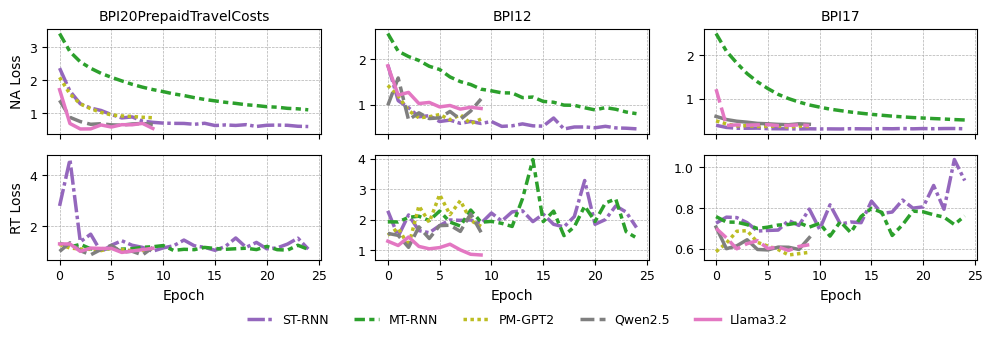

In [ ]:
LOGS_TO_PLOT = ["BPI20PrepaidTravelCosts", "BPI12", "BPI17"]
HUE_ORDER=["ST-RNN", "MT-RNN", "PM-GPT2", "Qwen2.5", "Llama3.2"]
HUE_MAP = {
    "ST-RNN": "ST-RNN",
    "rnn": "MT-RNN", 
    "pm-gpt2": "PM-GPT2", 
    "qwen25-05b": "Qwen2.5", 
    "llama32-1b": "Llama3.2"
}

l = losses.melt(
    id_vars=["log", "backbone"], 
    var_name="Loss",
    value_name="Value"
).copy()
l = l.dropna(subset=["Value"])
l["Epoch"] = l.groupby(["log", "backbone", "Loss"]).cumcount()
bpis = l[(l.log.isin(["BPI17", "BPI12", ])) & (l.backbone.str.startswith(("qwen","llama"))) & (~l.Epoch.between(4, 15))] # skipping warm-up
l = l.drop(bpis.index, axis=0)
l["Epoch"] = l.groupby(["log", "backbone", "Loss"]).cumcount()

l["backbone"] = l["backbone"].map(HUE_MAP)

fig, axes = plt.subplots(2, len(LOGS_TO_PLOT), figsize=(12, 3), sharex=True)
axes_iter = iter(axes.flatten())

count = 0
for metric in l.Loss.unique():
    for log in LOGS_TO_PLOT:
        ax = next(axes_iter)
        tmp = l[
            (l.Loss == metric) & 
            (l.log == log) &
            ((l.backbone.str.endswith('RNN')) | ((~l.backbone.str.endswith('RNN')) & (l.Epoch < 10)))
        ]
        sns.lineplot(
            data=tmp,
            x="Epoch",
            y="Value",
            hue="backbone",
            hue_order=HUE_ORDER,
            ax=ax,
            style="backbone",
            linewidth=2.5,
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{metric}")
        ax.set_title(f"{log}")
        count+=1
        if count != 5:
            ax.legend_.remove()
        else:
            handles, labels = [], []
            ax.legend(
                handles=handles, 
                labels=labels, 
                title="", 
                ncol=5, 
                bbox_to_anchor=(1.55, -0.4)
            )

axes[1, 0].set_title("")
axes[1, 1].set_title("")
axes[1, 2].set_title("")

axes[0, 0].set_ylabel("NA Loss")
axes[0, 1].set_ylabel("")
axes[0, 2].set_ylabel("")
axes[1, 0].set_ylabel("RT Loss")
axes[1, 1].set_ylabel("")
axes[1, 2].set_ylabel("")

plt.savefig(f"/home/seidi/Repositories/papers/icpm25-paper/figures/results/losses.pdf", dpi=300)

## plots that did not fit in the paper

Text(0, 0.5, '')

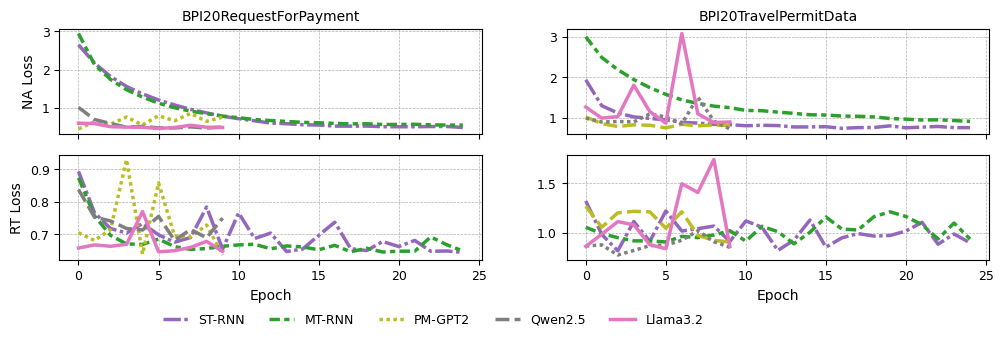

In [17]:
LOGS_TO_PLOT = ["BPI20RequestForPayment", "BPI20TravelPermitData"]
HUE_ORDER=["ST-RNN", "MT-RNN", "PM-GPT2", "Qwen2.5", "Llama3.2"]
HUE_MAP = {
    "ST-RNN": "ST-RNN",
    "rnn": "MT-RNN", 
    "pm-gpt2": "PM-GPT2", 
    "qwen25-05b": "Qwen2.5", 
    "llama32-1b": "Llama3.2"
}

l = losses.melt(
    id_vars=["log", "backbone"], 
    var_name="Loss",
    value_name="Value"
).copy()
l = l.dropna(subset=["Value"])
l["Epoch"] = l.groupby(["log", "backbone", "Loss"]).cumcount()
bpis = l[(l.log.isin(["BPI17", "BPI12", ])) & (l.backbone.str.startswith(("qwen","llama"))) & (~l.Epoch.between(4, 15))]
l = l.drop(bpis.index, axis=0)
l["Epoch"] = l.groupby(["log", "backbone", "Loss"]).cumcount()

l["backbone"] = l["backbone"].map(HUE_MAP)

fig, axes = plt.subplots(2, len(LOGS_TO_PLOT), figsize=(12, 3), sharex=True)
axes_iter = iter(axes.flatten())

count = 0
for metric in l.Loss.unique():
    for log in LOGS_TO_PLOT:
        ax = next(axes_iter)
        tmp = l[
            (l.Loss == metric) & 
            (l.log == log) &
            ((l.backbone.str.endswith('RNN')) | ((~l.backbone.str.endswith('RNN')) & (l.Epoch < 10)))
        ]
        sns.lineplot(
            data=tmp,
            x="Epoch",
            y="Value",
            hue="backbone",
            hue_order=HUE_ORDER,
            ax=ax,
            style="backbone",
            linewidth=2.5,
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{metric}")
        ax.set_title(f"{log}")
        count+=1
        if count != 3:
            ax.legend_.remove()
        else:
            handles, labels = [], []
            ax.legend(
                handles=handles, 
                labels=labels, 
                title="", 
                ncol=5, 
                bbox_to_anchor=(1.55, -0.4)
            )

axes[1, 0].set_title("")
axes[1, 1].set_title("")
# axes[1, 2].set_title("")

axes[0, 0].set_ylabel("NA Loss")
axes[0, 1].set_ylabel("")
# axes[0, 2].set_ylabel("")
axes[1, 0].set_ylabel("RT Loss")
axes[1, 1].set_ylabel("")
# axes[1, 2].set_ylabel("")